In [11]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
from numpy import cos , sin

In [3]:
img = cv2.imread("img.jpeg")
template = cv2.imread("template.jpeg")


# Convert it to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

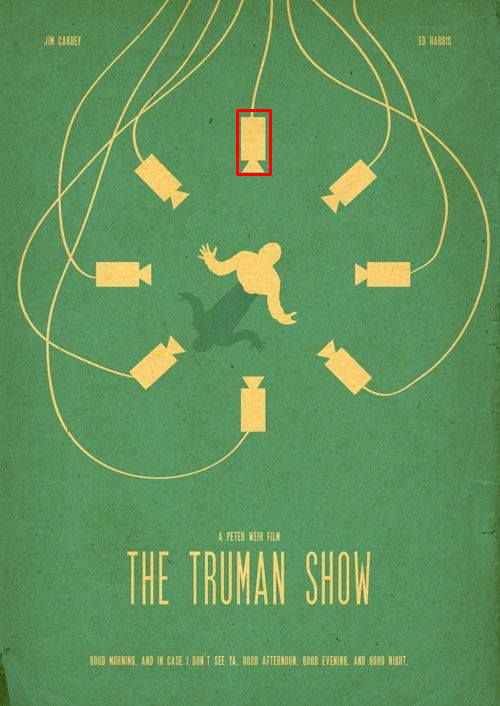

In [10]:
new_img = img.copy()
# Store width and height of template in w and h
w, h = template_gray.shape[::-1]
 
# Perform match operations.
res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

 
# Specify a threshold
threshold = 0.8
 
# Store the coordinates of matched area in a numpy array
loc = np.where(res >= threshold)
# Draw a rectangle around the matched region.
for pt in zip(*loc[::-1]):
  cv2.rectangle(new_img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
  break
 
# Show the final image with the matched area.
cv2_imshow(new_img)

In [ ]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [ ]:
rot_range = [0,360]
rot_interval = 45
image_maxwh = img_gray.shape


res = []
for next_angle in range(rot_range[0], rot_range[1], rot_interval):
  if next_angle == 0:
      rotated_template = template_gray
  else:
      rotated_template = rotate_image(template_gray, next_angle)

  res.append([cv2.matchTemplate(img_gray, rotated_template, cv2.TM_CCOEFF_NORMED) , next_angle])

In [ ]:
def findCenter(image , start_point, end_point , rotation):
  center_point = [(start_point[0]+end_point[0])//2, (start_point[1]+end_point[1])//2]
  height = end_point[1] - start_point[1]
  width = end_point[0] - start_point[0]
  angle = np.radians(rotation)

  return center_point , height , width , angle

In [ ]:
def rotated_rectangle(image, start_point, end_point, color, thickness, rotation=0):
    center_point , height , width , angle = findCenter(image, start_point, end_point , rotation)
    
    # Determine the coordinates of the 4 corner points
    rotated_rect_points = []
    x = center_point[0] + ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] - ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1]- ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] + ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    cv2.polylines(image, np.array([rotated_rect_points], np.int32), True, color, thickness)

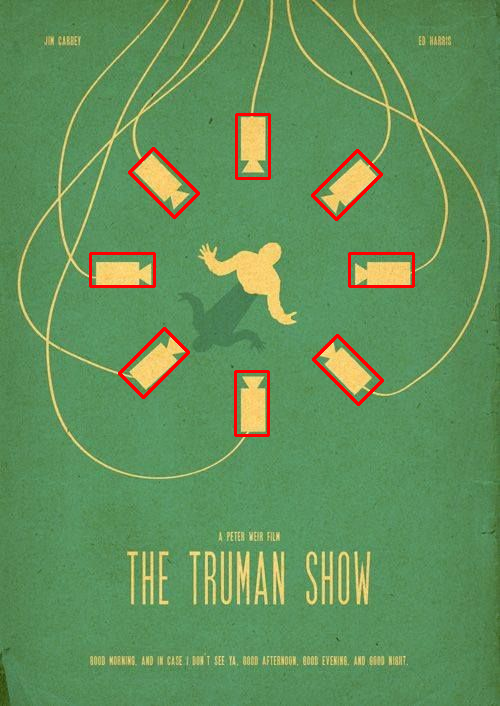

In [ ]:
new_img = img.copy()
# Store width and height of template in w and h
w, h = template_gray.shape[::-1]

Centers = []
for item , rotate in res :
  # Specify a threshold
  threshold = 0.8

  # Store the coordinates of matched area in a numpy array
  loc = np.where(item >= threshold)
  i = 0
  # Draw a rectangle around the matched region.
  for pt in zip(*loc[::-1]):
    times = 0
    flag = True
    # Centers.append([pt, rotate])
    center , height , width , angle = findCenter(new_img, pt, (pt[0] + w, pt[1] + h) , rotate)
    for i , point in enumerate(Centers):
      center_point , height , width , angle = findCenter(new_img, point[0], (point[0][0] + w, point[0][1] + h) , point[1])
      
      if center[0] <= center_point[0] + width and center[0] >= center_point[0] - width:
        if center[1] <= center_point[1] + height and center[1] >= center_point[1] - height:
          if point[2] < 200:
            Centers[i] = [((point[0][0]+pt[0]) / 2 , (point[0][1]+pt[1]) / 2) ,point[1] ,point[2]+1]
          flag = False
          break

    if flag:
      Centers.append([(pt[0] , pt[1]), rotate , times])

for item in Centers:
  pt = item[0]
  rotated_rectangle(new_img , pt, (pt[0] + w, pt[1] + h) , (0, 0, 255), 2 , item[1])
 
# # Show the final image with the matched area.
cv2_imshow(new_img)